In [4]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt

con = duckdb.connect("../warehouse/eth_cex.duckdb")
df = con.execute("""
    SELECT *
    FROM v_cex_eth_macro_with_network
    ORDER BY day
""").df()
con.close()

df["day"] = pd.to_datetime(df["day"])
df.head()

,day,eth_inflow,eth_outflow,netflow_eth,sample_block_number,block_tx_count,block_gas_used_ratio,block_base_fee_gwei,price_usd,daily_return,rolling_vol_7d
0,2025-11-11,216521.585611,3.418531e+05,-125331.475807,23775553,229,0.718900,0.104599,3417.76,-0.042067,0.037797
1,2025-11-12,589057.625757,6.113139e+05,-22256.281107,23782708,78,0.134873,0.085546,3414.92,-0.000831,0.034394
2,2025-11-13,934615.381695,8.356771e+05,98938.306340,23789845,246,0.408239,0.075539,3231.54,-0.053700,0.038519
3,2025-11-14,970659.009771,1.003621e+06,-32961.891537,23796987,174,0.259361,0.528868,3112.40,-0.036868,0.035875
4,2025-11-15,411741.041409,3.631103e+05,48630.705398,23804153,172,0.343687,0.072943,3167.88,0.017825,0.037814


In [8]:
df.describe()[[
    "eth_inflow",
    "eth_outflow",
    "netflow_eth",
    "block_tx_count",
    "block_base_fee_gwei",
    "block_gas_used_ratio",
    "daily_return"
]]


,eth_inflow,eth_outflow,netflow_eth,block_tx_count,block_base_fee_gwei,block_gas_used_ratio,daily_return
count,31.000000,3.100000e+01,31.000000,31.000000,31.000000,31.000000,31.000000
mean,487120.151110,4.994092e+05,-12289.035293,206.161290,0.144391,0.533452,-0.002866
min,86695.182259,9.732087e+04,-126647.733490,78.000000,0.019572,0.118283,-0.064251
25%,270385.425028,3.380770e+05,-41995.912475,160.000000,0.044615,0.352424,-0.027777
50%,482277.844086,4.802605e+05,-22256.281107,199.000000,0.080050,0.456451,0.000703
75%,654331.749202,6.416582e+05,14521.940716,236.000000,0.135444,0.713015,0.014696
max,970659.009771,1.003621e+06,107469.099159,374.000000,1.211551,0.999952,0.070381
std,252198.856326,2.437218e+05,59035.290258,62.991056,0.223381,0.270480,0.035492


The summary statistics show that exchange liquidity and network activity fluctuate much more aggressively than ETH price returns, highlighting that price is a smoother outcome of more volatile underlying dynamics.

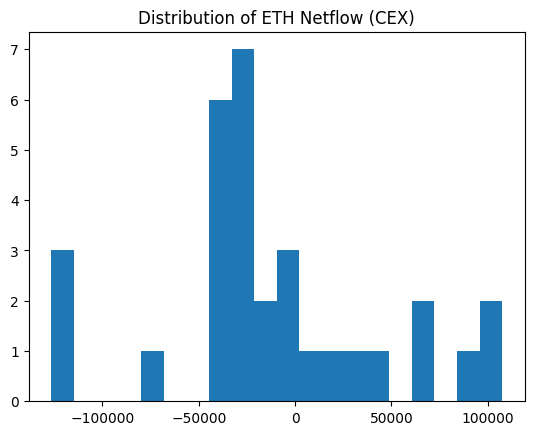

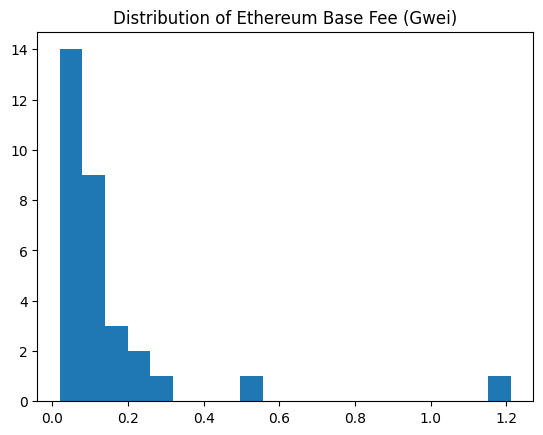

In [9]:
plt.figure()
plt.hist(df["netflow_eth"], bins=20)
plt.title("Distribution of ETH Netflow (CEX)")
plt.show()

plt.figure()
plt.hist(df["block_base_fee_gwei"], bins=20)
plt.title("Distribution of Ethereum Base Fee (Gwei)")
plt.show()


*Key insights from Distribution of ETH Netflow (CEX)

Most days are negative or near zero
→ ETH was more often leaving exchanges than entering

A few extreme negative days (far left)
→ Large withdrawals → likely long-term holding or staking

Positive netflow days exist but are fewer
→ Occasional ETH moving back to exchanges (potential selling preparation)

*Key insights from Distribution of Ethereum Base Fee (Gwei)

Most days have low base fees
→ No sustained network stress

A few extreme spikes
→ Short-lived events, not a long-term trend

Healthy pattern
→ Ethereum usage without constant congestion

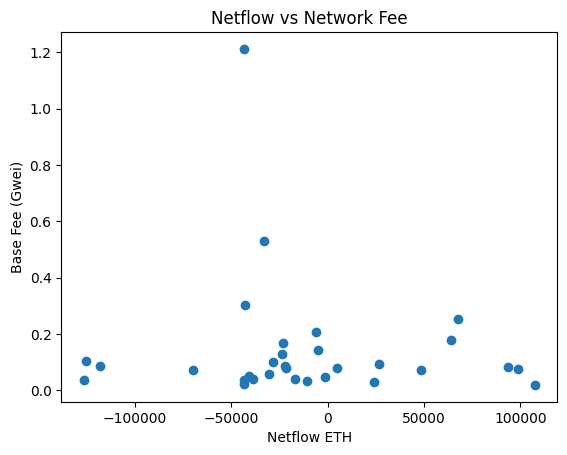

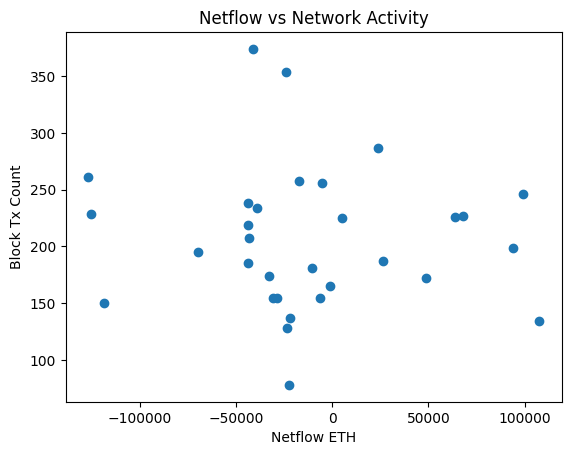

In [12]:
plt.figure()
plt.scatter(df["netflow_eth"], df["block_base_fee_gwei"])
plt.xlabel("Netflow ETH")
plt.ylabel("Base Fee (Gwei)")
plt.title("Netflow vs Network Fee")
plt.show()

plt.figure()
plt.scatter(df["netflow_eth"], df["block_tx_count"])
plt.xlabel("Netflow ETH")
plt.ylabel("Block Tx Count")
plt.title("Netflow vs Network Activity")
plt.show()


***Scatter: Netflow vs Network Fee

Question this chart asks: “When ETH moves in/out of exchanges, does the network get busy?”

Answer: No clear relationship

Large outflows sometimes happen with low fees

Large inflows also happen with low fees

One fee spike ≠ netflow extreme

Interpretation: Exchange transfers are not the main driver of network congestion. Fees reflect broader activity, not just exchange behavior

This confirms: Netflow ≠ network demand


***Scatter: Netflow vs Network Activity (tx count)

Question: “When ETH leaves or enters exchanges, does transaction activity change?”

Answer: No strong pattern

High activity days occur at different netflow levels

Low activity days also spread across netflow values

Interpretation:

Exchange flows are portfolio decisions. Network activity reflects on-chain usage. These are different layers of behavior.

In [13]:
threshold = df["netflow_eth"].quantile(0.2)  # bottom 20%

outflow_days = df[df["netflow_eth"] <= threshold]
normal_days = df[df["netflow_eth"] > threshold]

outflow_days[["block_base_fee_gwei", "block_tx_count"]].mean(), \
normal_days[["block_base_fee_gwei", "block_tx_count"]].mean()
# It appears that days with large ETH outflows to CEXs have higher base fees and transaction counts on average.

(block_base_fee_gwei      0.224803
 block_tx_count         211.000000
 dtype: float64,
 block_base_fee_gwei      0.120938
 block_tx_count         204.750000
 dtype: float64)

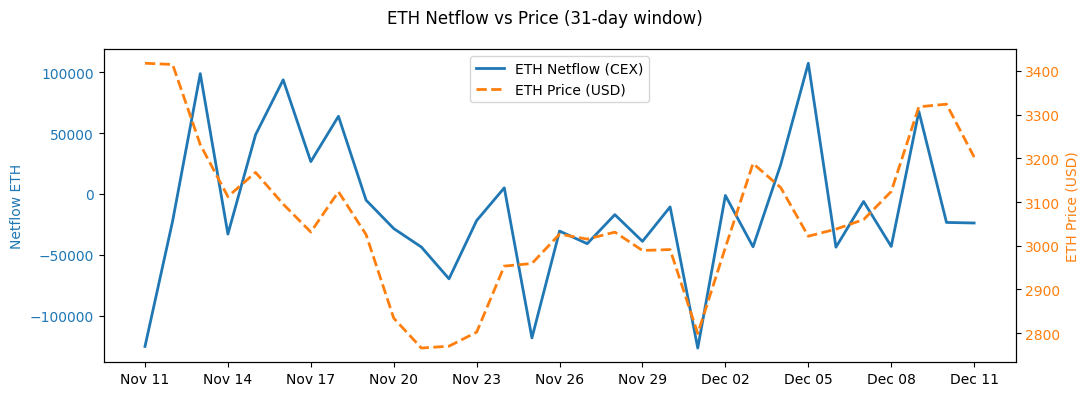

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax1 = plt.subplots(figsize=(11, 4))

# Netflow (LEFT axis)
line1, = ax1.plot(
    df["day"],
    df["netflow_eth"],
    color="tab:blue",
    linewidth=2,
    label="ETH Netflow (CEX)"
)
ax1.set_ylabel("Netflow ETH", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Price (RIGHT axis)
ax2 = ax1.twinx()
line2, = ax2.plot(
    df["day"],
    df["price_usd"],
    color="tab:orange",
    linestyle="--",
    linewidth=2,
    label="ETH Price (USD)"
)
ax2.set_ylabel("ETH Price (USD)", color="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:orange")

# X-axis formatting
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))


fig.suptitle("ETH Netflow vs Price (31-day window)")

# Legend (combine both lines)
lines = [line1, line2]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="upper center")

fig.tight_layout()
plt.show()




This visualization overlays:

ETH netflow (left axis)

ETH price (right axis)

over the same 31-day window.

*Key observations: There is no consistent one-to-one relationship between netflow direction and same-day price movement. Periods of negative netflow can coincide with: price stabilization, price increases or price declines. Timing mismatches are common.

*Interpretation:
Netflow does not determine price direction.
Instead, it provides context about liquidity positioning and sell-side risk.

EDA takeaway:
Liquidity conditions often shift before price outcomes become visible, but the relationship is non-linear and regime-dependent.